In [ ]:
import kagglehub

path = kagglehub.dataset_download("sulianova/cardiovascular-disease-dataset")

print("Path to dataset files:", path)

## Importing the required modules

In [120]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

## Reading the dataset and preprocessing it

In [118]:
df = pd.read_csv("cardio_train.csv",sep=';')
df.dropna(inplace=True)

In [110]:
x = df[["age", "gender", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc", "smoke", "active", "alco"]]
y = df[["cardio"]].values
x = pd.get_dummies(x, columns=["cholesterol", "gluc", "gender"]).astype(int)
print(x.shape)

(70000, 16)


In [88]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

x_train = torch.tensor(x_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

import pickle
with open("scaler.pkl", 'wb') as fl:
    fl.write(pickle.dumps(scaler))

## Defining the model

In [89]:
class HeartModel(nn.Module):
    def __init__(self):
        super(HeartModel, self).__init__()
        self.fc1 = nn.Linear(16, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = self.fc8(x)
        return x

## Training the model

In [76]:
model = HeartModel()

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 150

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    logits = model(x_train)
    loss = loss_function(logits, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1)%10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 10, Loss: 0.6650
Epoch 20, Loss: 0.6299
Epoch 30, Loss: 0.6162
Epoch 40, Loss: 0.6080
Epoch 50, Loss: 0.5811
Epoch 60, Loss: 0.5671
Epoch 70, Loss: 0.5601
Epoch 80, Loss: 0.5525
Epoch 90, Loss: 0.5493
Epoch 100, Loss: 0.5450
Epoch 110, Loss: 0.5425
Epoch 120, Loss: 0.5412
Epoch 130, Loss: 0.5407
Epoch 140, Loss: 0.5374
Epoch 150, Loss: 0.5359


## Evaluating it by making predictions

In [105]:
model.eval()

with torch.no_grad():
    logits_test = model(x_test)
    predictions = torch.sigmoid(logits_test)
    predictions = (predictions > 0.5).float()
    
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100:.2f}%")

precision = precision_score(y_test.numpy(), predictions.numpy())
print(f"Precision: {precision * 100:.2f}%")

f1 = f1_score(y_test.numpy(), predictions.numpy())
print(f"F1-score: {f1:.4f}")

Accuracy: 73.37%
Precision: 74.88%
F1-score: 0.7261


## Saving the model

In [ ]:
torch.save(model, 'model.pth')

## Plotting the confusion matrix

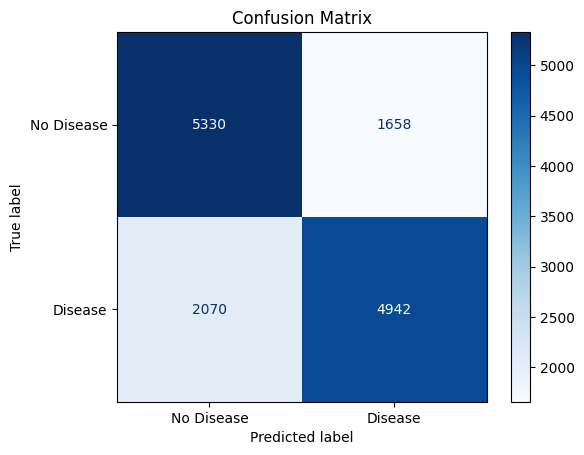

In [121]:
cm = confusion_matrix(y_test.numpy(), predictions.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Disease', 'Disease'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
